<a href="https://colab.research.google.com/github/datasciencewithsam/CatvsDog-imageclassification/blob/main/Cat_vs_Dog_Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This project demonstrtates the classfication on Cat vs Dog dataset using CNN(Convolutional Neural Network)
# We will use the dataset from https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip for this work
# Dataset has been derived into training and validation pieces already . Hence we nedd to keep those datasets in two separete folders.

import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data')
zip_ref.close()


In [3]:
#Create separate train and validation directory as the structure has been followed in the original dataset.

base_dir = '/content/sample_data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])


['cat.976.jpg', 'cat.230.jpg', 'cat.493.jpg', 'cat.626.jpg', 'cat.186.jpg', 'cat.123.jpg', 'cat.821.jpg', 'cat.740.jpg', 'cat.675.jpg', 'cat.746.jpg']
['dog.362.jpg', 'dog.98.jpg', 'dog.667.jpg', 'dog.766.jpg', 'dog.332.jpg', 'dog.19.jpg', 'dog.290.jpg', 'dog.529.jpg', 'dog.262.jpg', 'dog.481.jpg']


All the pixel values range between 0 to 255, so to normalize the images I have used ImageDataGenerator class which will genrate batches of normalized input images based out of the train and validation directory. Target size of the image selected as (150,150) but it can be rescaled later. Since this project only deals with only two class (Cat and Dog) of images so the class_mode selected as 'binary' for generating the flow of training and validation images.  





In [4]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


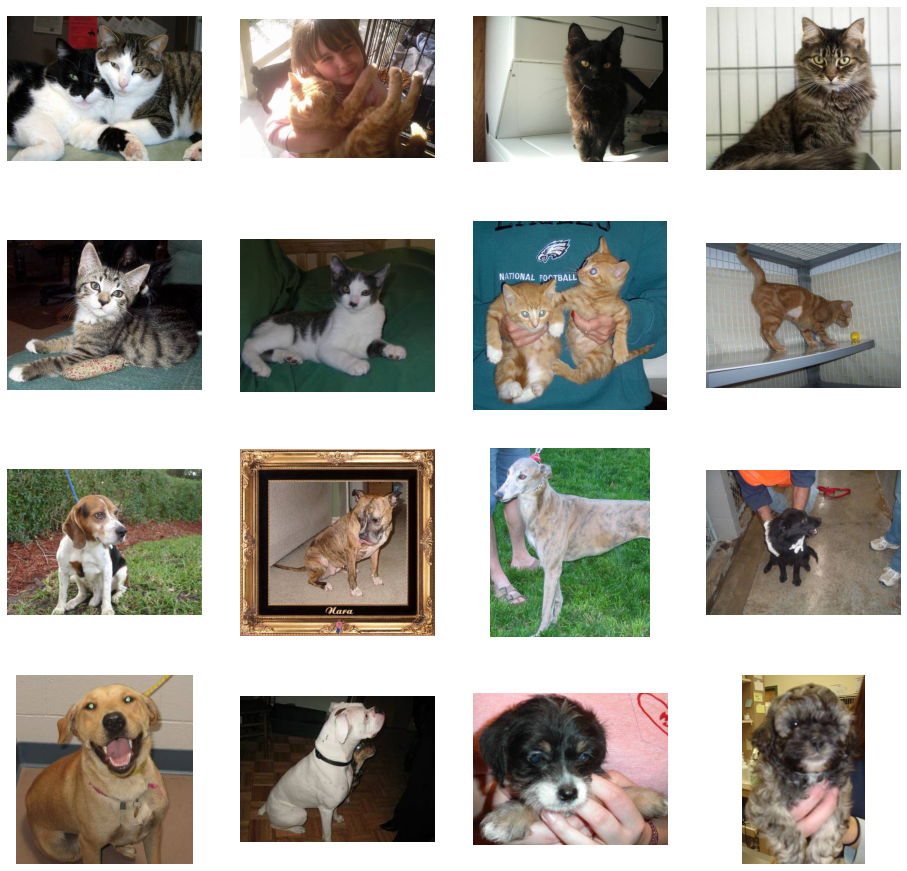

In [5]:
# Let's see some sample images
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Now, it's time to build the model for classification. I have used Keras module of Tensorflow framework to obtain most common model for this work. In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model. Brief overview of the model components :

**Conv2D:** is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.

**Sequential:** That defines a SEQUENCE of layers in the neural network

**Flatten:** Change the multi-dimesional input to one dimension for better model processing

**maxpooling2d:** Sample based discretization process to down-sample an input representation(input image, hidden layers, matrix etc.) in order to simplify the processing.

**Dense:** Add layers of neurons and each neuron comes with activation functions such as Relu or Sigmoid. Relu is more computionally efficient because the gradient value is either 0 or 1 as opposed to sigmoid which keep fractions of 0 to 1 as gradient value. Relu seems to be converges faster than sigmoid function.

**softmax:** It take the maxium value coming our of output layer which saves a lot of coding work.



In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The next thing to do, now the model is defined, is to actually build it. In order to do that, I compile it with an optimizer and loss function as before. Based on the method of classification binary loss function has been selected for compliation purpose. 

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Implement callback function which will terminate model train program once train accuracy reaches ceratin limit.

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9970):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

Next step is to train the model using model.fit() function. To train the model I need to selected a very important parameter called epochs which is nothing but the count of one forward and backward propagation of the training samples. Based on the number of batch sizes I selected during image generation phase I have to derive number of training examples will be processes during each epoch.

In [9]:
callbacks = myCallback()
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2,
      callbacks=[callbacks])

Epoch 1/50
100/100 - 20s - loss: 0.6871 - accuracy: 0.5420 - val_loss: 0.6730 - val_accuracy: 0.5980 - 20s/epoch - 203ms/step
Epoch 2/50
100/100 - 9s - loss: 0.6463 - accuracy: 0.6250 - val_loss: 0.6344 - val_accuracy: 0.6100 - 9s/epoch - 90ms/step
Epoch 3/50
100/100 - 9s - loss: 0.5987 - accuracy: 0.6805 - val_loss: 0.6172 - val_accuracy: 0.6310 - 9s/epoch - 90ms/step
Epoch 4/50
100/100 - 9s - loss: 0.5634 - accuracy: 0.7070 - val_loss: 0.6127 - val_accuracy: 0.6490 - 9s/epoch - 91ms/step
Epoch 5/50
100/100 - 9s - loss: 0.5364 - accuracy: 0.7340 - val_loss: 0.5758 - val_accuracy: 0.6880 - 9s/epoch - 90ms/step
Epoch 6/50
100/100 - 9s - loss: 0.5136 - accuracy: 0.7405 - val_loss: 0.5490 - val_accuracy: 0.7200 - 9s/epoch - 90ms/step
Epoch 7/50
100/100 - 9s - loss: 0.4859 - accuracy: 0.7655 - val_loss: 0.5417 - val_accuracy: 0.7180 - 9s/epoch - 90ms/step
Epoch 8/50
100/100 - 9s - loss: 0.4542 - accuracy: 0.7705 - val_loss: 0.5715 - val_accuracy: 0.7150 - 9s/epoch - 90ms/step
Epoch 9/50
10

Validating the accuracy of training and validation

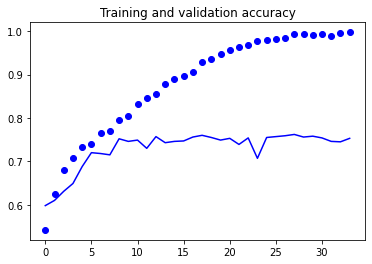

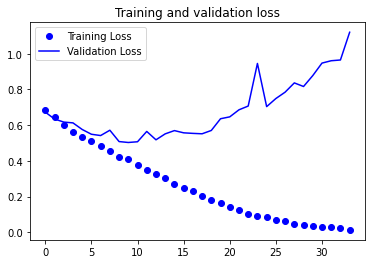

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The Training Accuracy is close to 100%, and the validation accuracy is in the 70%-80% range. This is a great example of overfitting which can be avoided using image augmentation technique. 

In [12]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving dog.2000.jpg to dog.2000.jpg
[1.]
dog.2000.jpg is a dog
